In [43]:
library("httr")
library("jsonlite")
library("ggplot2")

# <span style="color:green">Einschub: Politiker finden</span>

Wir legen zunächst den String fest, nachdem wir suchen wollen:

In [44]:
search_term <- "Gysi"

Nun wird die Grund-URL für die API Abfrage von Politikern festgelegt. Also http://mediamonitoring.gesis.org/api plus "/politicians/" (Alternative: "/organizations/"). Dann werden Suchbegriff und URL zusammen"geklebt". 

In [45]:
base <- "http://mediamonitoring.gesis.org/api/politicians/"

url_pol_search <- paste(base,"all/search/?names_contain=",search_term, sep="")

Abrufen mit GET, Einlesen als Textform mit "content", Flattening zu Dataframe mit "fromJson"

In [46]:
fromJSON(content(GET(url_pol_search), "text", encoding="UTF-8"), flatten = TRUE)

,politician_id,name,firstname,affiliation,fb_ids,tw_ids,wp_ids,wp_titles,fb_sns,tw_sns
,<int>,<chr>,<chr>,<chr>,<list>,<list>,<list>,<list>,<list>,<list>
1,2078,Gysi,Gregor,Linke,42497482692,888289790,1827,Gregor Gysi,gregor.gysi,gregorgysi


<span style="color:green">**Hiernach das originale Notebook, wie wir es aus der grafischen Oberfläche abgerufen hatten:** </span>


# Politician Activity on Twitter

The parameters in the cell below can be adjusted to explore other politicians and time frames.

### How to explore other politicians?
The ***politician_id*** is an internal identifier that connects the different social media accounts. You can [use this other notebook](../politicians.ipynb?autorun=true) to get other the identifiers of other politicians.

***Alternatively***, you can direcly use the [politicians API](http://mediamonitoring.gesis.org/api/politicians/swagger/), or access it with the [SMM Wrapper](https://pypi.org/project/smm-wrapper/).



search for politician ID

## A. Set Up parameters

In [47]:
# Parameter: 
politician_id = 2078 #<<- Diesen haben wir gerade oben herausgefunden!
from_date = '2017-07-01'
to_date = '2019-11-31'
aggregation = 'month'

## B. Using the SMM Politician API

In [48]:
# URLs festlegen ("Base" ist eine Wiederholung von oben)
base <- "http://mediamonitoring.gesis.org/api/politicians/"
url_tweets <- paste(base,"twitter/tweets_by/politicians/", politician_id, "/?", sep="")
url_replies <- paste(base,"twitter/replies_to/politicians/", politician_id, "/?", sep="")

#Parameter von oben in ein Dictonary übergeben (könnte man auch direkt hier machen)
params = list(
    from_date=from_date,
    to_date=to_date,
    aggregate_by=aggregation
)

# Abfragen für Tweets und Anworten
tweets_by = as.data.frame(fromJSON(content(GET(url_tweets, query=params), "text", encoding="UTF-8"), flatten = TRUE))
replies_to = as.data.frame(fromJSON(content(GET(url_replies, query=params), "text", encoding="UTF-8"), flatten = TRUE))
# Merging beider Dataframes über "labels", also die Datumsangaben
merged = merge(tweets_by, replies_to, by='labels')

volle URL zum Ausprobieren im Browser: 
"http://mediamonitoring.gesis.org/api/politicians/twitter/tweets_by/politicians/2078/?from_date=2017-07-01&to_date=2019-11-01&aggregate_by=month&format=json"

## C. Plotting

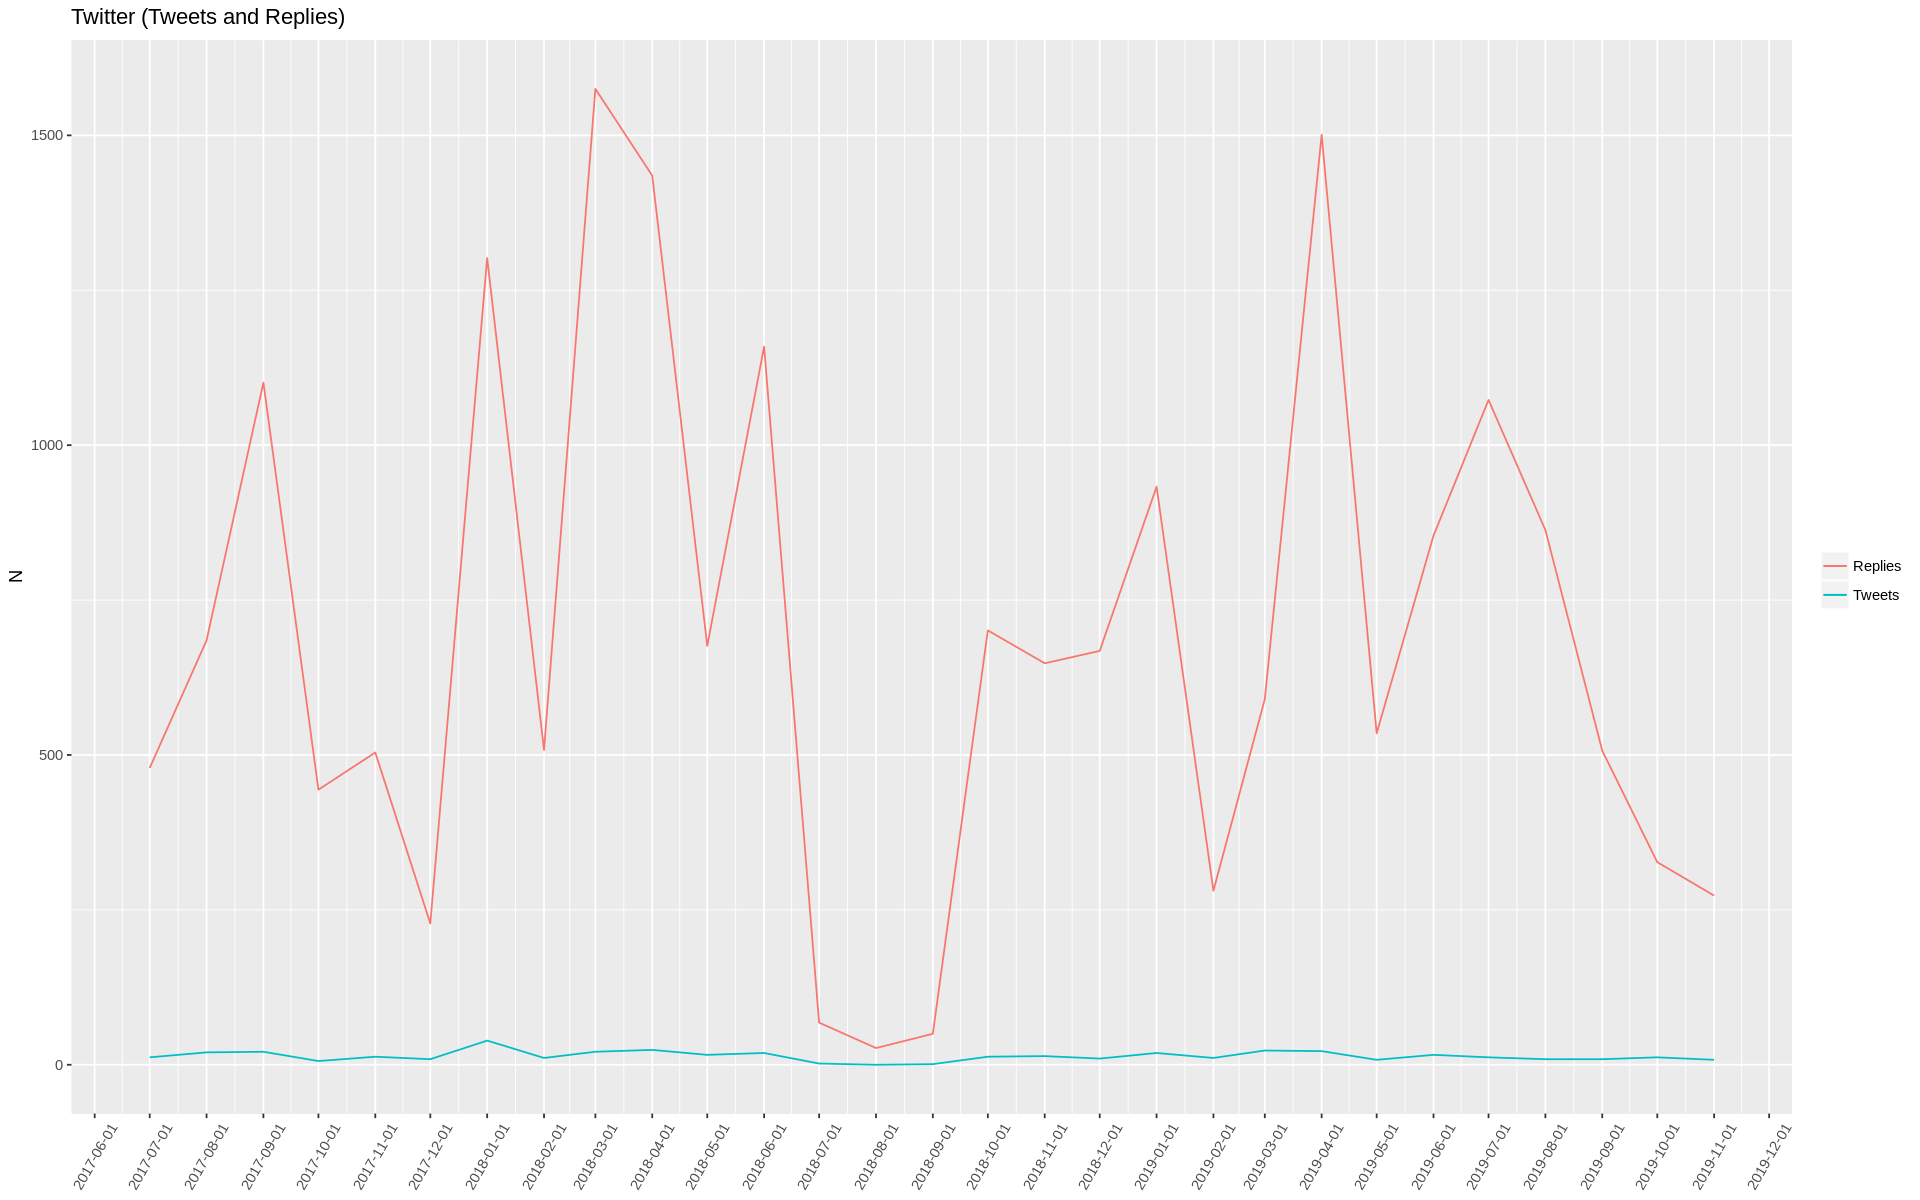

In [49]:
#Festlegen der Plot-Größe nach Bedarf
options(repr.plot.width=16, repr.plot.height=10)

# Tweets und Antworten mit GGplot als getrennte Linien ausgeben
ggplot(data = merged, mapping = aes(as.Date(labels))) +
  geom_line(aes(y = values.x, color="Tweets")) +
  geom_line(aes(y = values.y, color="Replies")) +
  labs(title = "Twitter (Tweets and Replies)", y = "N") +
  theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
  scale_x_date(date_breaks = "1 month") 

# <span style="color:green">Nun etwas Neues: Vergleich mehrerer Politiker</span>

In [50]:
params = list(
    from_date='2017-07-01',
    to_date='2019-11-31',
    aggregate_by='month'   
)

In [51]:
politician_ids = list('996','1145','2505', '2078') #Einige vorher herausgesuchte Politikter in einer Liste -> Beer: 996, Barley: 1145, Brandner: 2505, Gysi: 2078

In [52]:
# Hier gehen wir bei der Zusammenfügung etwas anders vor und bereiten zunächst Datenframes vor, an die wir die Datenframes der Politiker anfügen 
#Es gibt einen leeren DF für Tweets und einen für Antworten.
tweets_by <- data.frame()
replies_to <- data.frame()

#Jetzt ein Loop, der über alle Politikerids in unserer Liste läuft und sowohl Tweets als auch Replies zieht. 
for (i in seq_along(politician_ids)){
    #Urls für die Abfragen zusammenstellen für PolitikerID "i" in der Liste
    url_tweets <- paste(base,"twitter/tweets_by/politicians/", politician_ids[i], "/?", sep="")
    url_replies <- paste(base,"twitter/replies_to/politicians/", politician_ids[i], "/?", sep="")
    
    # Tweets ziehen für den momentanen Politiker und an den Haupt-DF hinten anhängen (und wir ziehen auch die Namen, 
    # da wir diese nicht immer haben, z.B. wenn wir die ID-Liste automatisch generiert hätten)
    tb_temp <- as.data.frame(fromJSON(content(GET(url_tweets, query=params), "text", encoding="UTF-8"), flatten = TRUE))
    tb_temp[['politician_id']] <- as.numeric(politician_ids[i]) 
    tb_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    tweets_by <- rbind(tweets_by, tb_temp)
    
    # Antworten ziehen für den momentanen Politiker und an den Haupt-DF  hinten anhängen
    rt_temp  <- as.data.frame(fromJSON(content(GET(url_replies, query=params), "text", encoding="UTF-8"), flatten = TRUE))
    rt_temp[['politician_id']] <- as.numeric(politician_ids[i]) 
    rt_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    replies_to <- rbind(replies_to, rt_temp)
    
    #jetzt Loop von vorne, falls noch eine ID übrig ist. 4 Durchläufe sollten in unserem Fall geschehen. D.h. zwei DFs aus je 4 Mini-DFs sollten resultieren. 
}

## Tweets

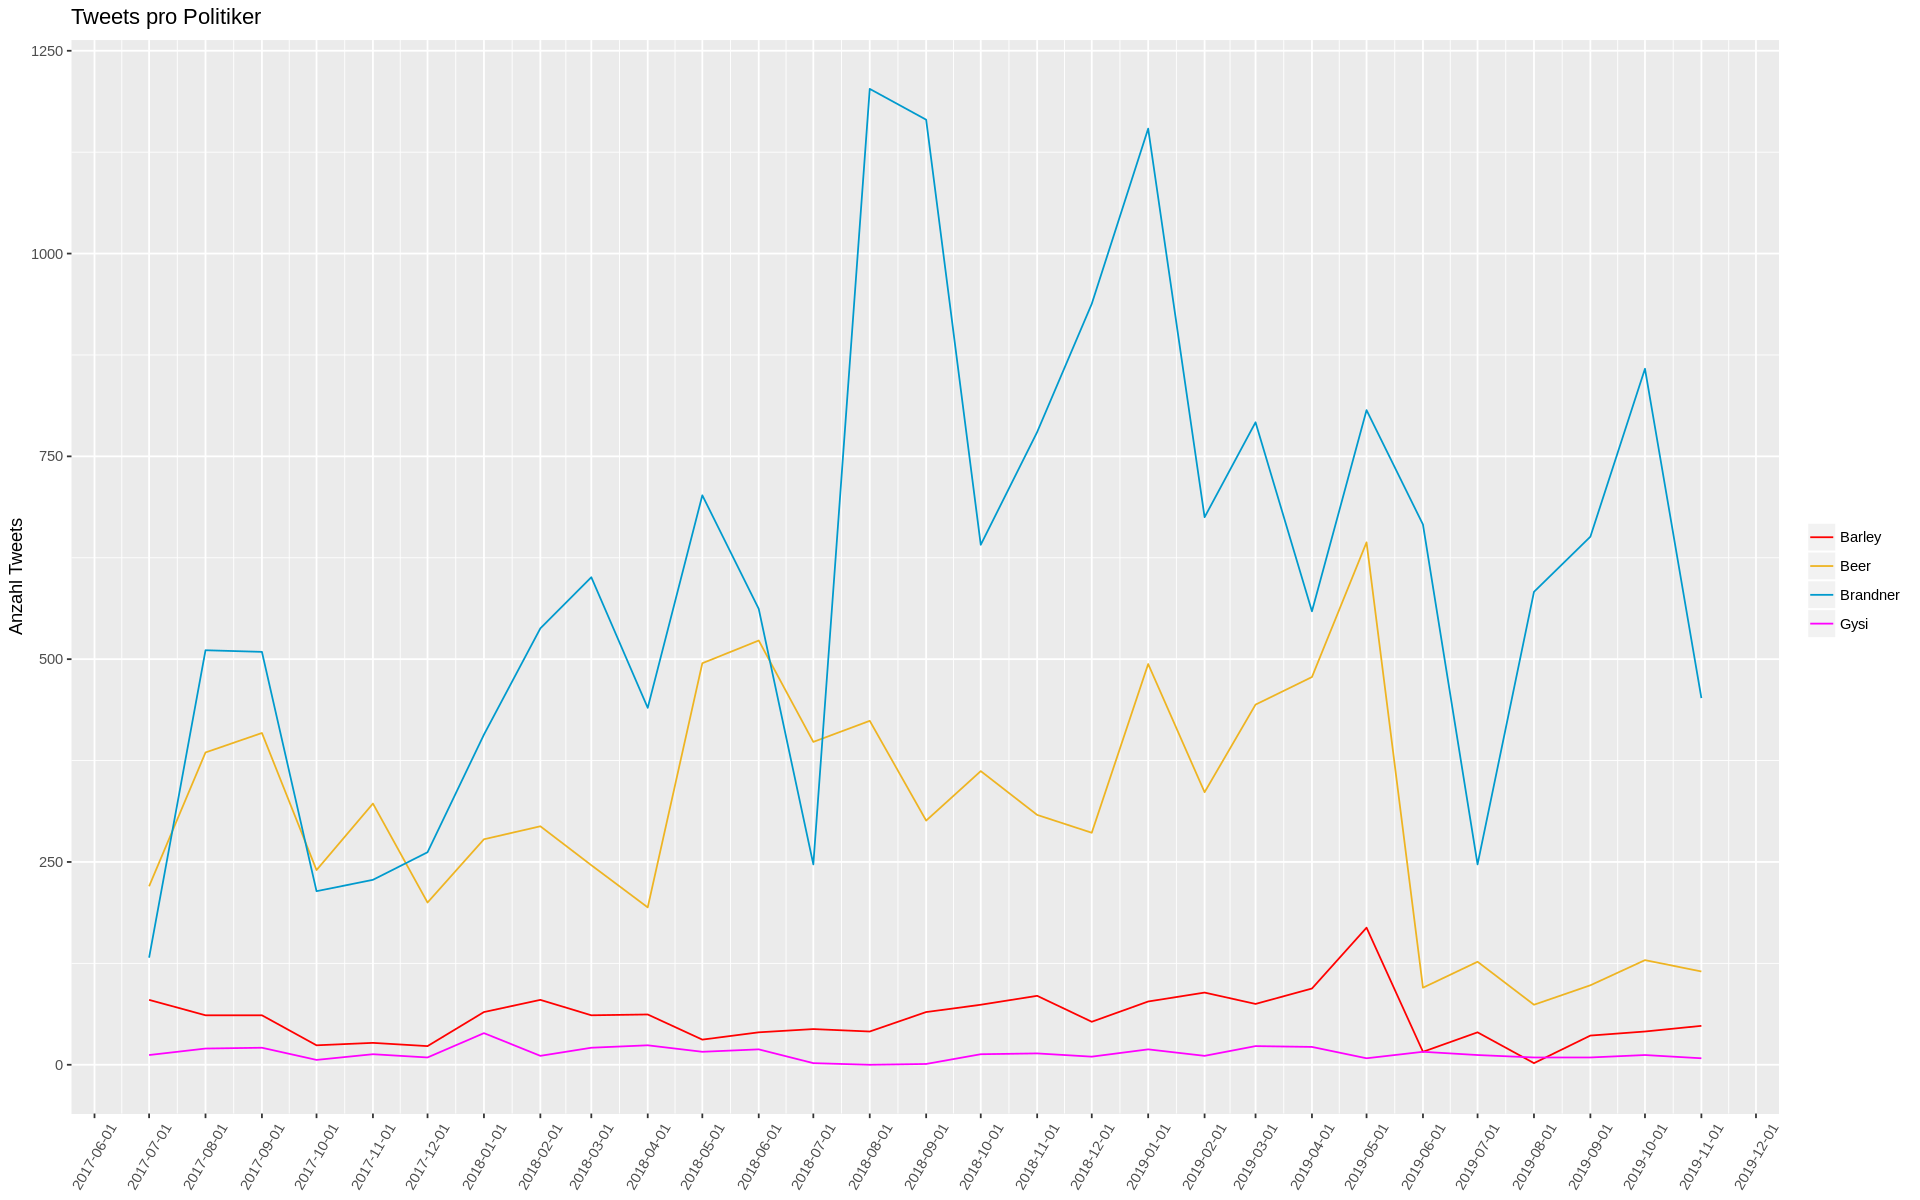

In [53]:
#Farbzuweisungen für unsere Politiker 

color_palette <- c("Barley"="red", "Beer"="goldenrod2","Gysi"="magenta1","Brandner"="deepskyblue3")

# Plotting der Tweets

ggplot(data=tweets_by, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Tweets pro Politiker", y = "Anzahl Tweets") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

## Antworten

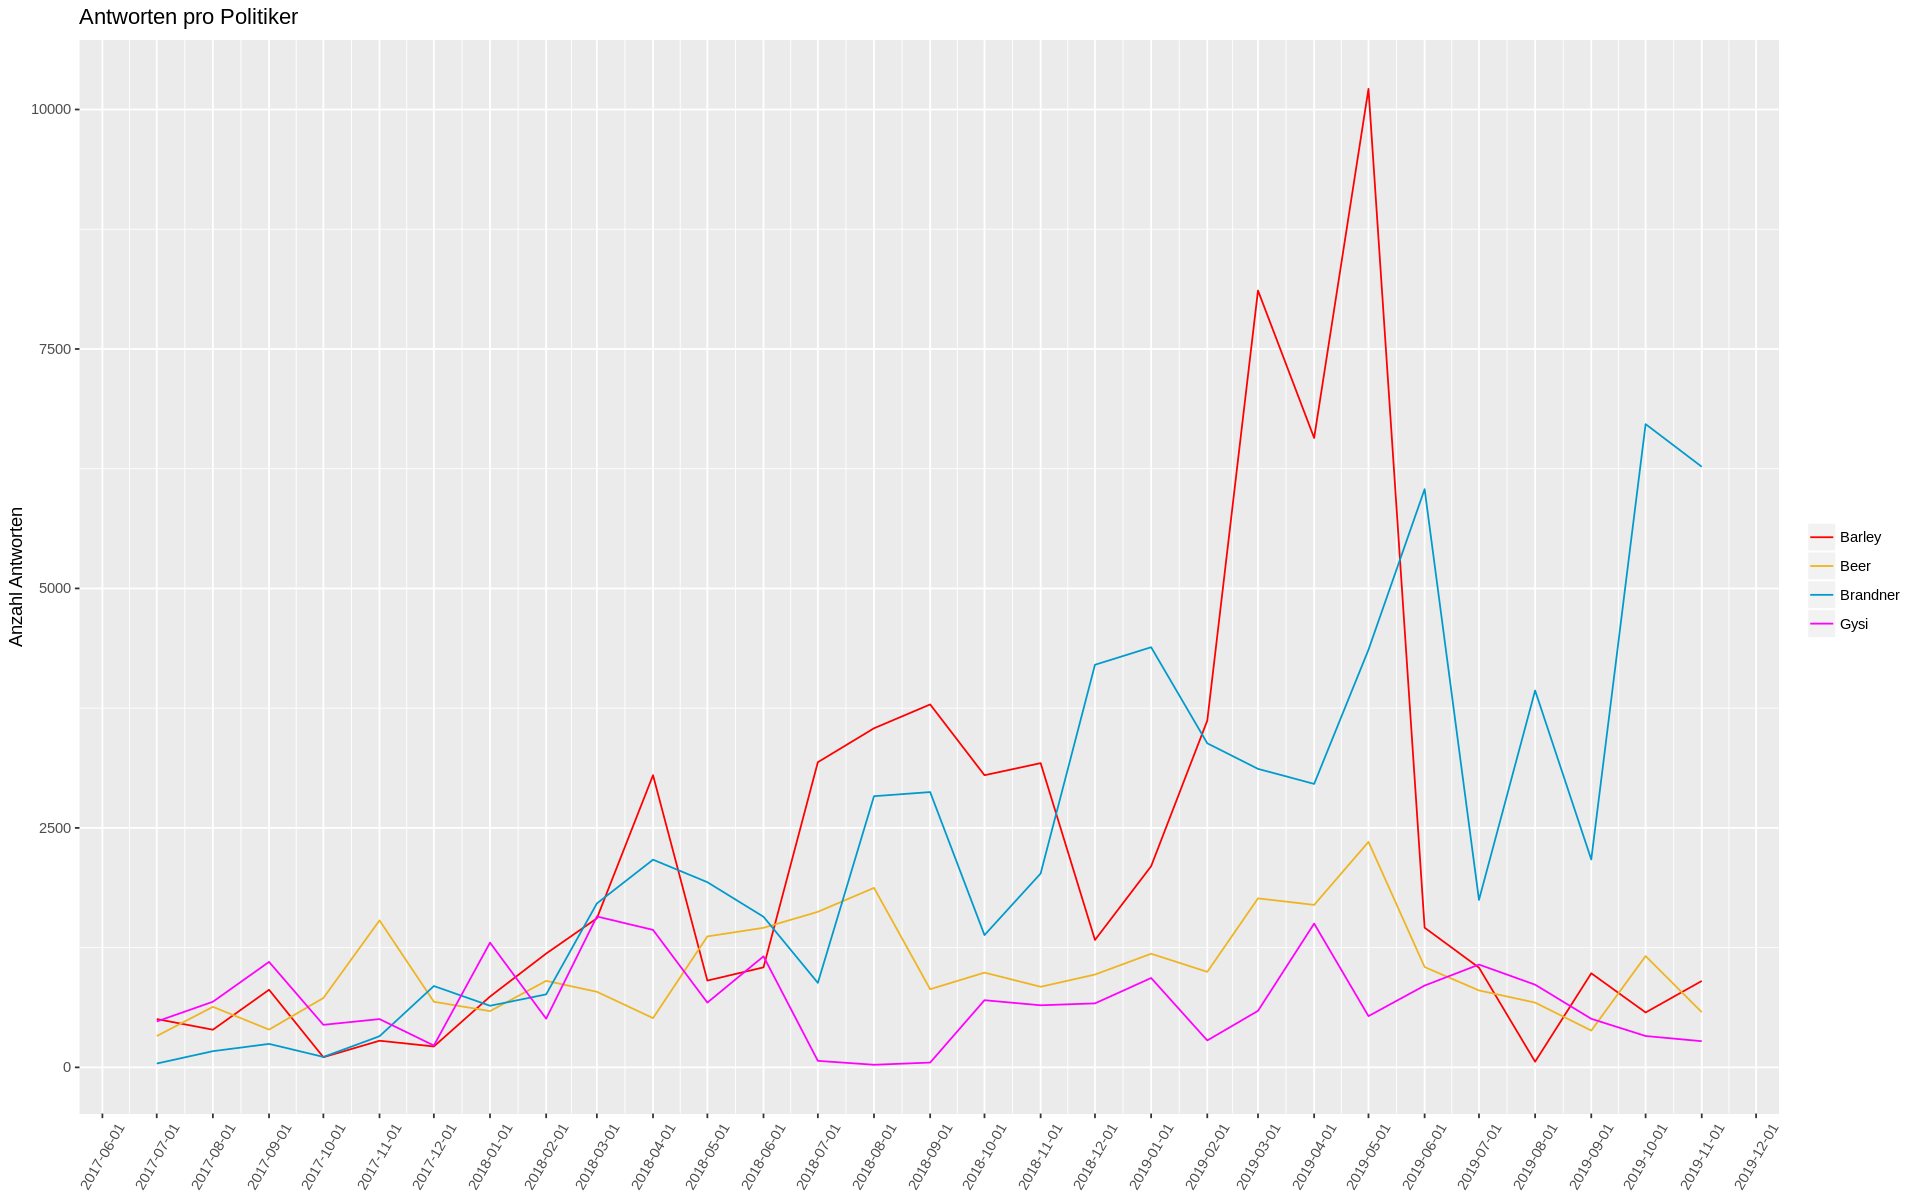

In [54]:
# Plotting der Antworten

ggplot(data=replies_to, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Antworten pro Politiker", y = "Anzahl Antworten") +
    scale_color_manual(name='politician_name',values=color_palette)+
    scale_x_date(date_breaks = "1 month") 

In [55]:
# Zusammenfügen von Tweets und Antworten, wie wir es auch beim Einzelpolitiker gemacht haben. Diesmal aber über Datum UND PolitikerID
all <- merge(tweets_by, replies_to, by=c('labels', 'politician_id'))

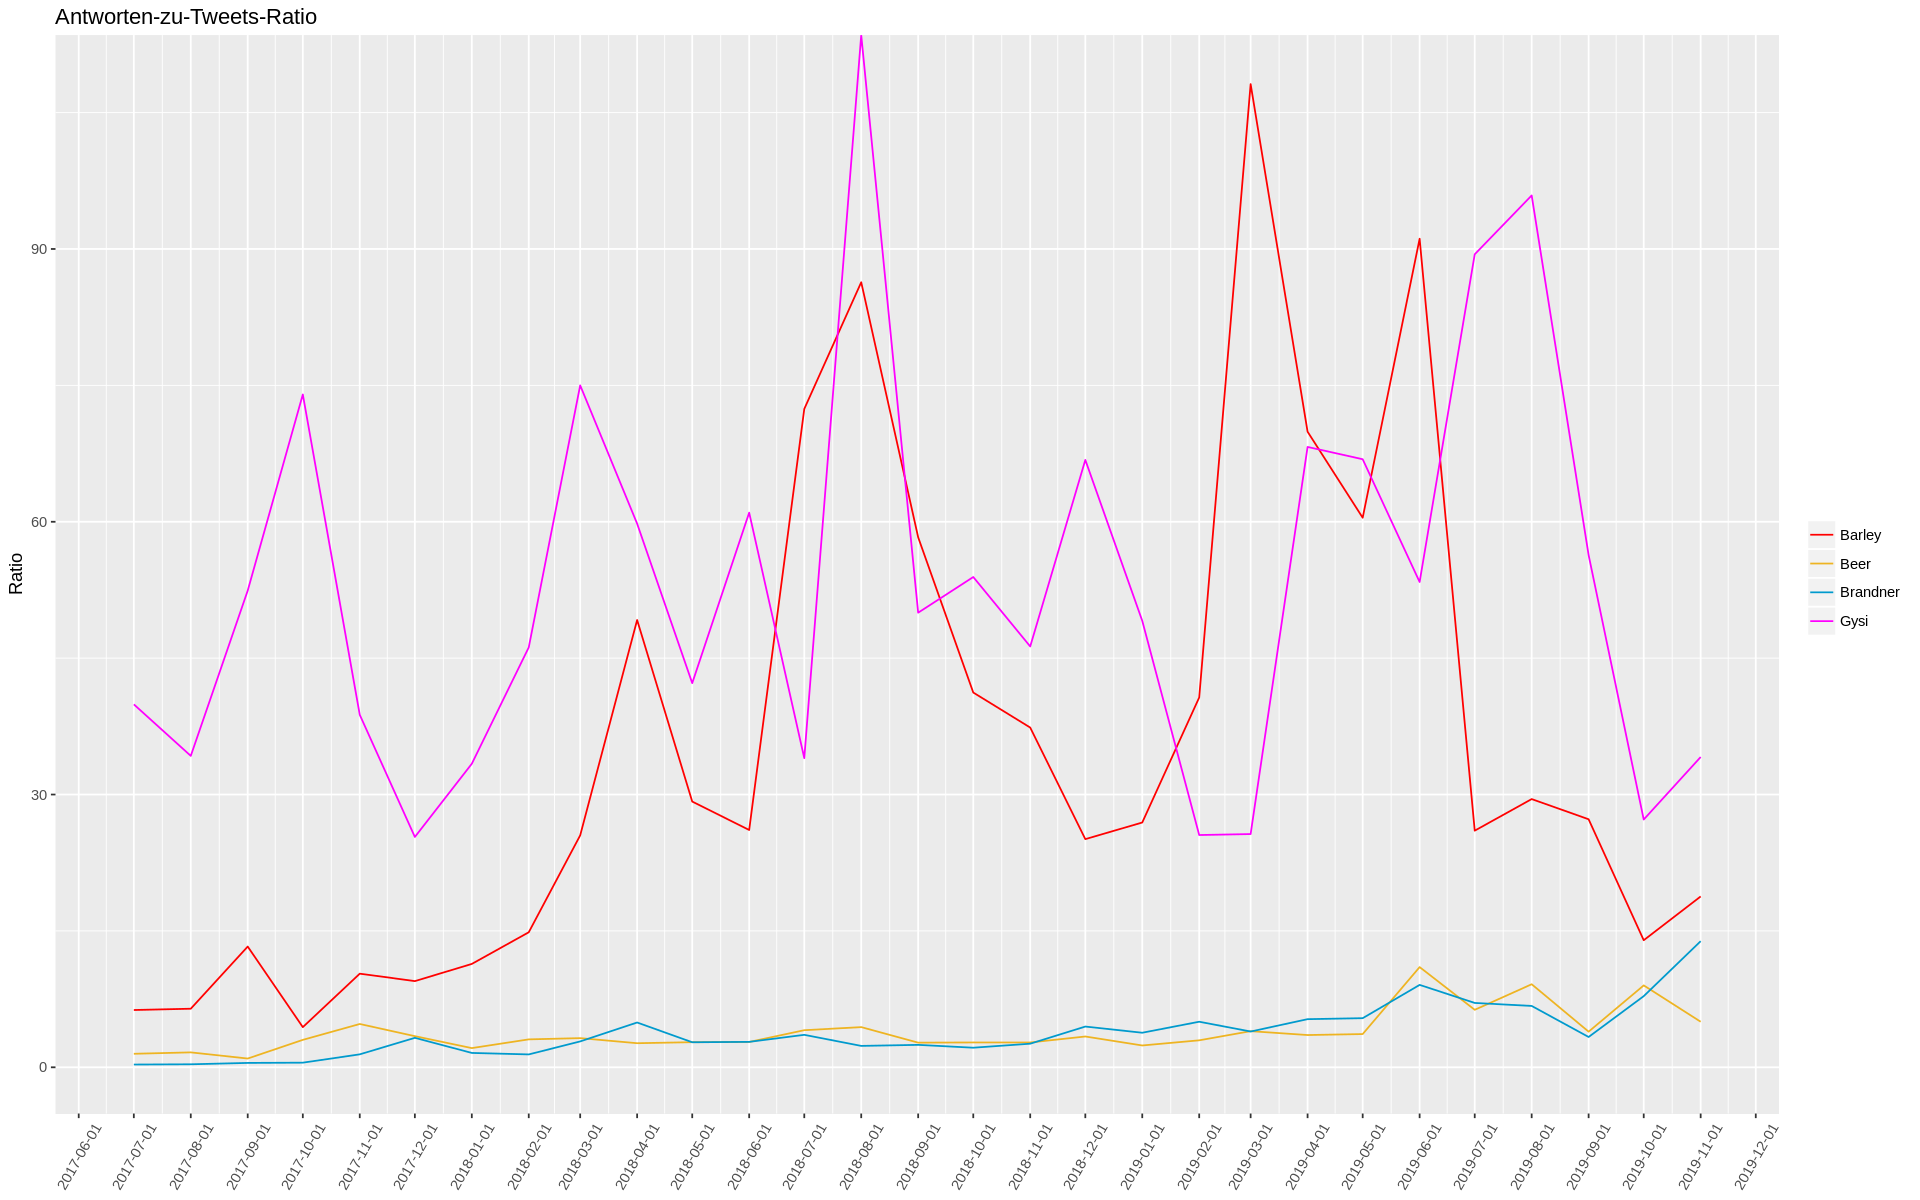

In [56]:
# plotting ratio between responses and tweets 
all <- merge(tweets_by, replies_to, by=c('labels', 'politician_id'))
ggplot(data=all, aes(x=as.Date(labels), y=values.y/values.x)) + 
    geom_line(aes(colour = factor(politician_name.x))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Antworten-zu-Tweets-Ratio", y = "Ratio") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

## Was sind das für Antworten? 
Vielleicht kann uns das "Wörterbuch des besorgten Bürgers" helfen. (Feustel et al. , http://sprachlos-blog.de/wdbb/), bereinigt um Begriffe, die andersgemeinte Homonyme haben.


Auszug: "Abendland|Abschiebeverhinderungsindustrie|Entvölkerung|Ficki-Ficki-Fachkräfte|"Political Correctness"|prorussisch|Rapefugees"

In [57]:
#WdbB aus Textdatei laden
wdbb <- paste(readLines("WdbB_short.txt"))

In [58]:
params = list(
    from_date='2017-07-01',
    to_date='2019-11-31',
    aggregate_by='month',
    text_contains=wdbb   #<- neuer Parameter, einfach anfügen:  Text den der Tweet enthalten muss, um gezählt/ausgegeben zu werden.  
    #D.h. im Normalfall müssten jetzt weniger Tweets resultieren 
)

In [59]:
#Gleiche Liste/Loop wie oben, aber nur für die Antworten, mit neuem Filterparameter

replies_to_wdbb <- data.frame()
for (i in seq_along(politician_ids)){
    url_replies <- paste(base,"twitter/replies_to/politicians/", politician_ids[i], "/?", sep="")
    
   # process replies to 
    rt_temp  <- as.data.frame(fromJSON(content(GET(url_replies, query=params), "text", encoding="UTF-8"), flatten = TRUE))
    rt_temp[['politician_id']] <- as.numeric(politician_ids[i])
    rt_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    replies_to_wdbb <- rbind(replies_to_wdbb, rt_temp) 
}

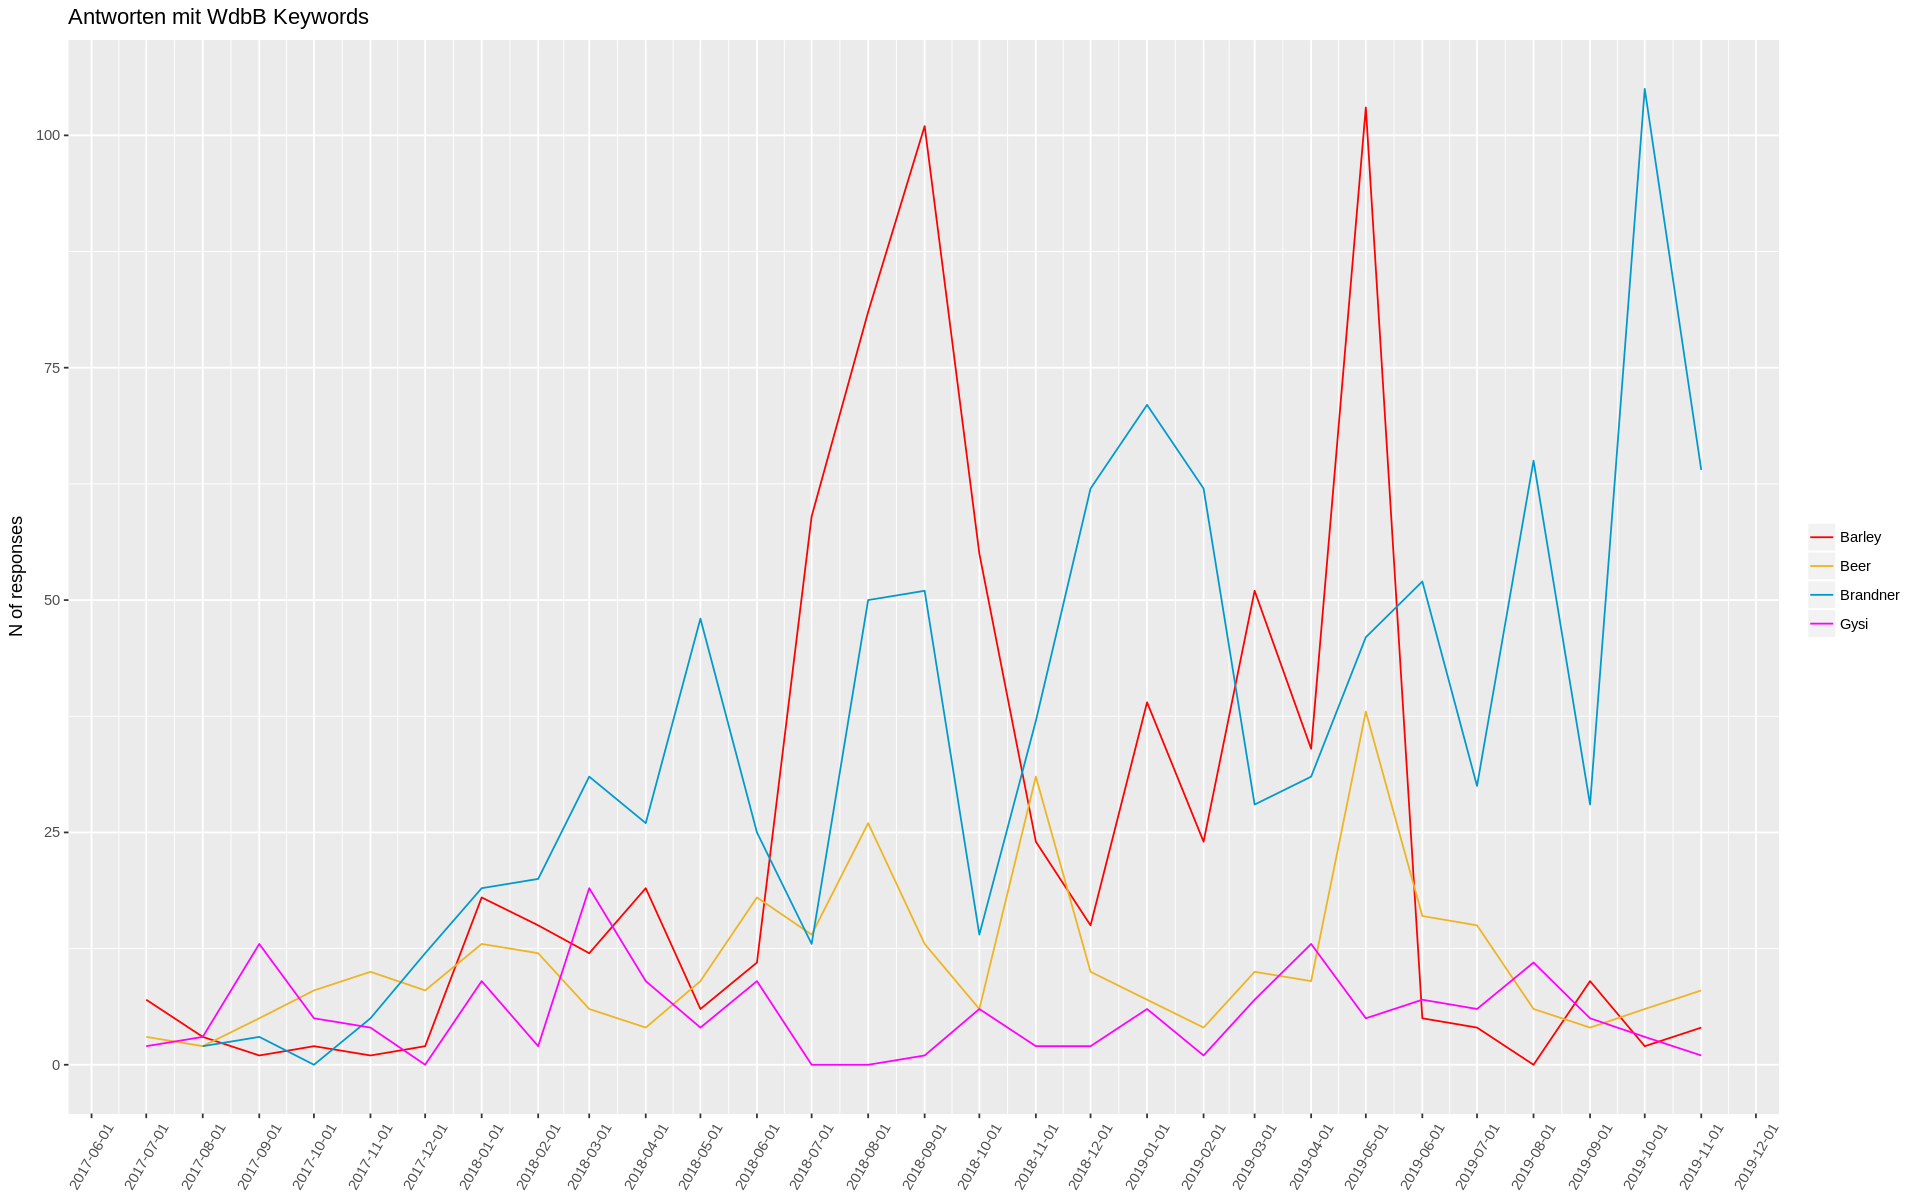

In [60]:
# Gefilterte Antworten geplottet 
ggplot(data=replies_to_wdbb, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Antworten mit WdbB Keywords", y = "N of responses") +
    scale_color_manual(values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

# Und auf Facebook? 

In [61]:
# Parameter funktionieren  hier genauso. Enddatum früher, da später keine Daten verfügbar. 
params_fb = list(
    from_date='2017-01-01',
    to_date='2018-08-31',
    aggregate_by='month'   
)

In [62]:
# Die Struktur ist nahezu identisch wie bei unserer Twitterabfrage, nur die Art der Abfrage via den Anhängen zur Base-URL ändert sich. 
posts_by <- data.frame()

for (i in seq_along(politician_ids)){
    url_posts <- paste(base,"facebook/posts_by/politicians/", politician_ids[i], "/?", sep="")
    url_comments <- paste(base,"facebook/comments_by/politicians/", politician_ids[i], "/?", sep="")
    
    # Abfrage Posts, anhängen DF an Liste
    pb_temp <- as.data.frame(fromJSON(content(GET(url_posts, query=params_fb), "text", encoding="UTF-8"), flatten = TRUE), stringsAsFactors = FALSE)
    pb_temp[['politician_id']] <- as.numeric(politician_ids[i]) 
    pb_temp[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    if(pb_temp[['response_type']][1] != "error") {
        posts_by <- rbind(posts_by, pb_temp) 
        }

}

## Posts 

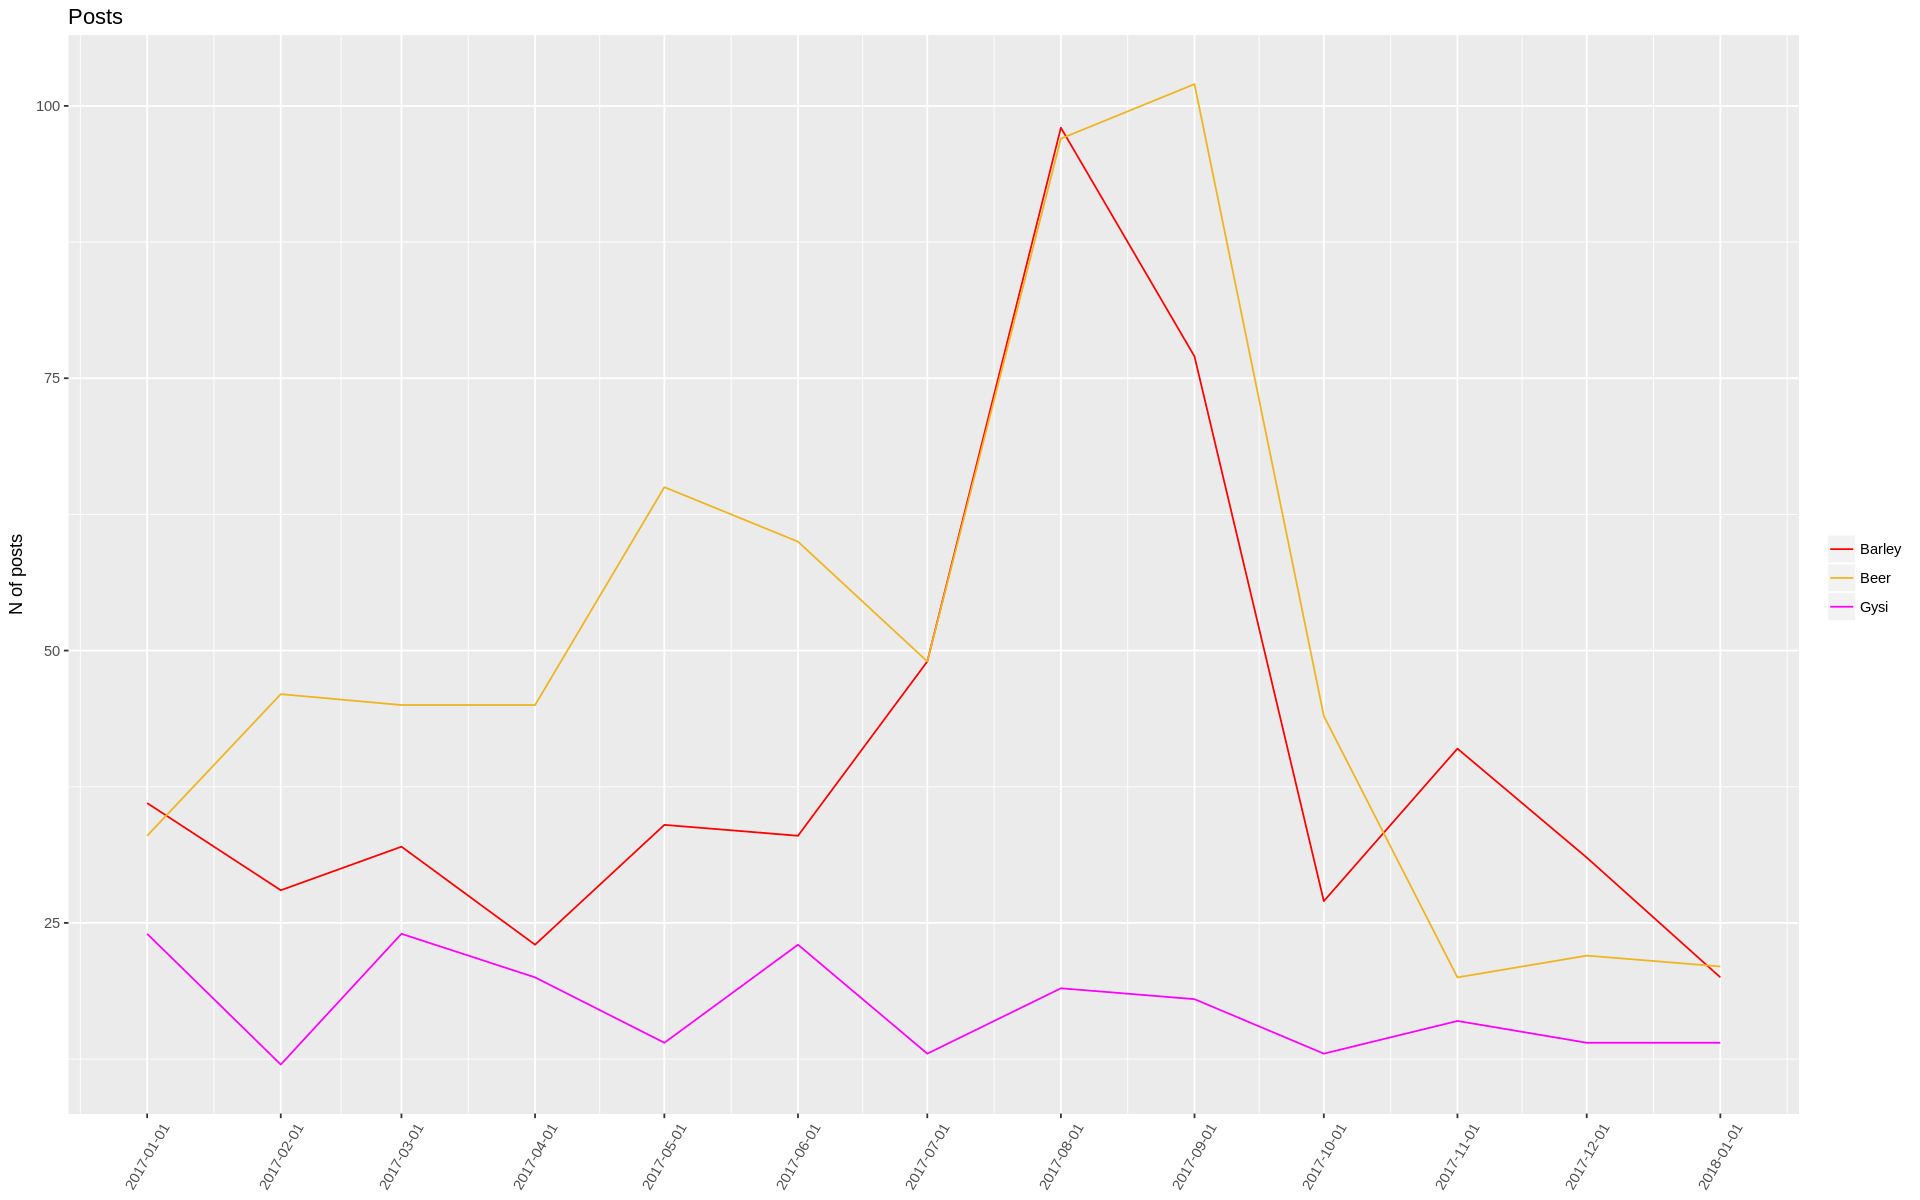

In [63]:
# Plotting: Posts

ggplot(data=posts_by, aes(x=as.Date(labels), y=values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Posts", y = "N of posts") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

## Engagement (reactions + shares + comments)

In [64]:
posts_by['engagement'] = posts_by['shares'] + posts_by['reactions'] + posts_by['replies']

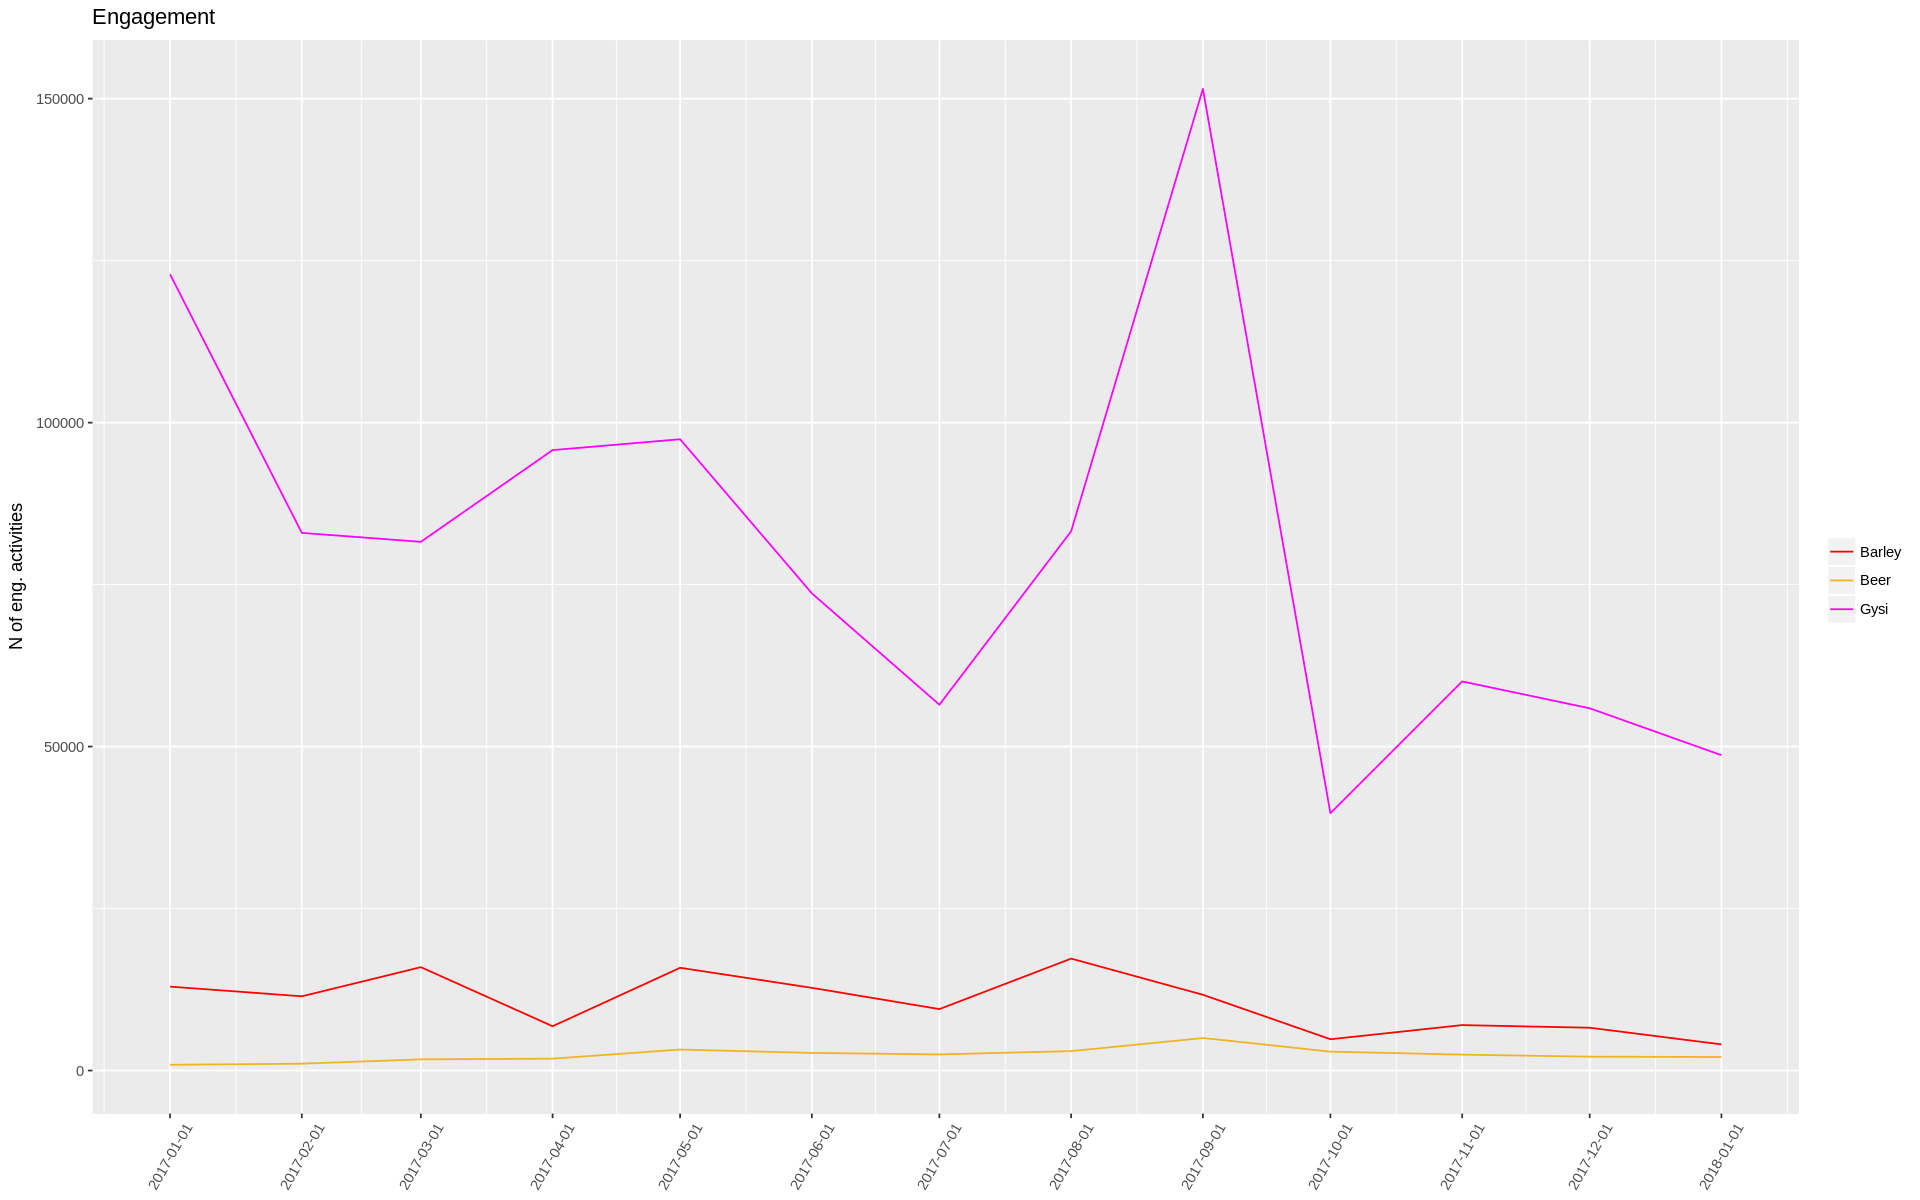

In [65]:
# Plotting des Engagement (comments + reactions + shares) 
ggplot(data=posts_by, aes(x=as.Date(labels), y=engagement)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Engagement", y = "N of eng. activities") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

## Ratio engagement-to-posts

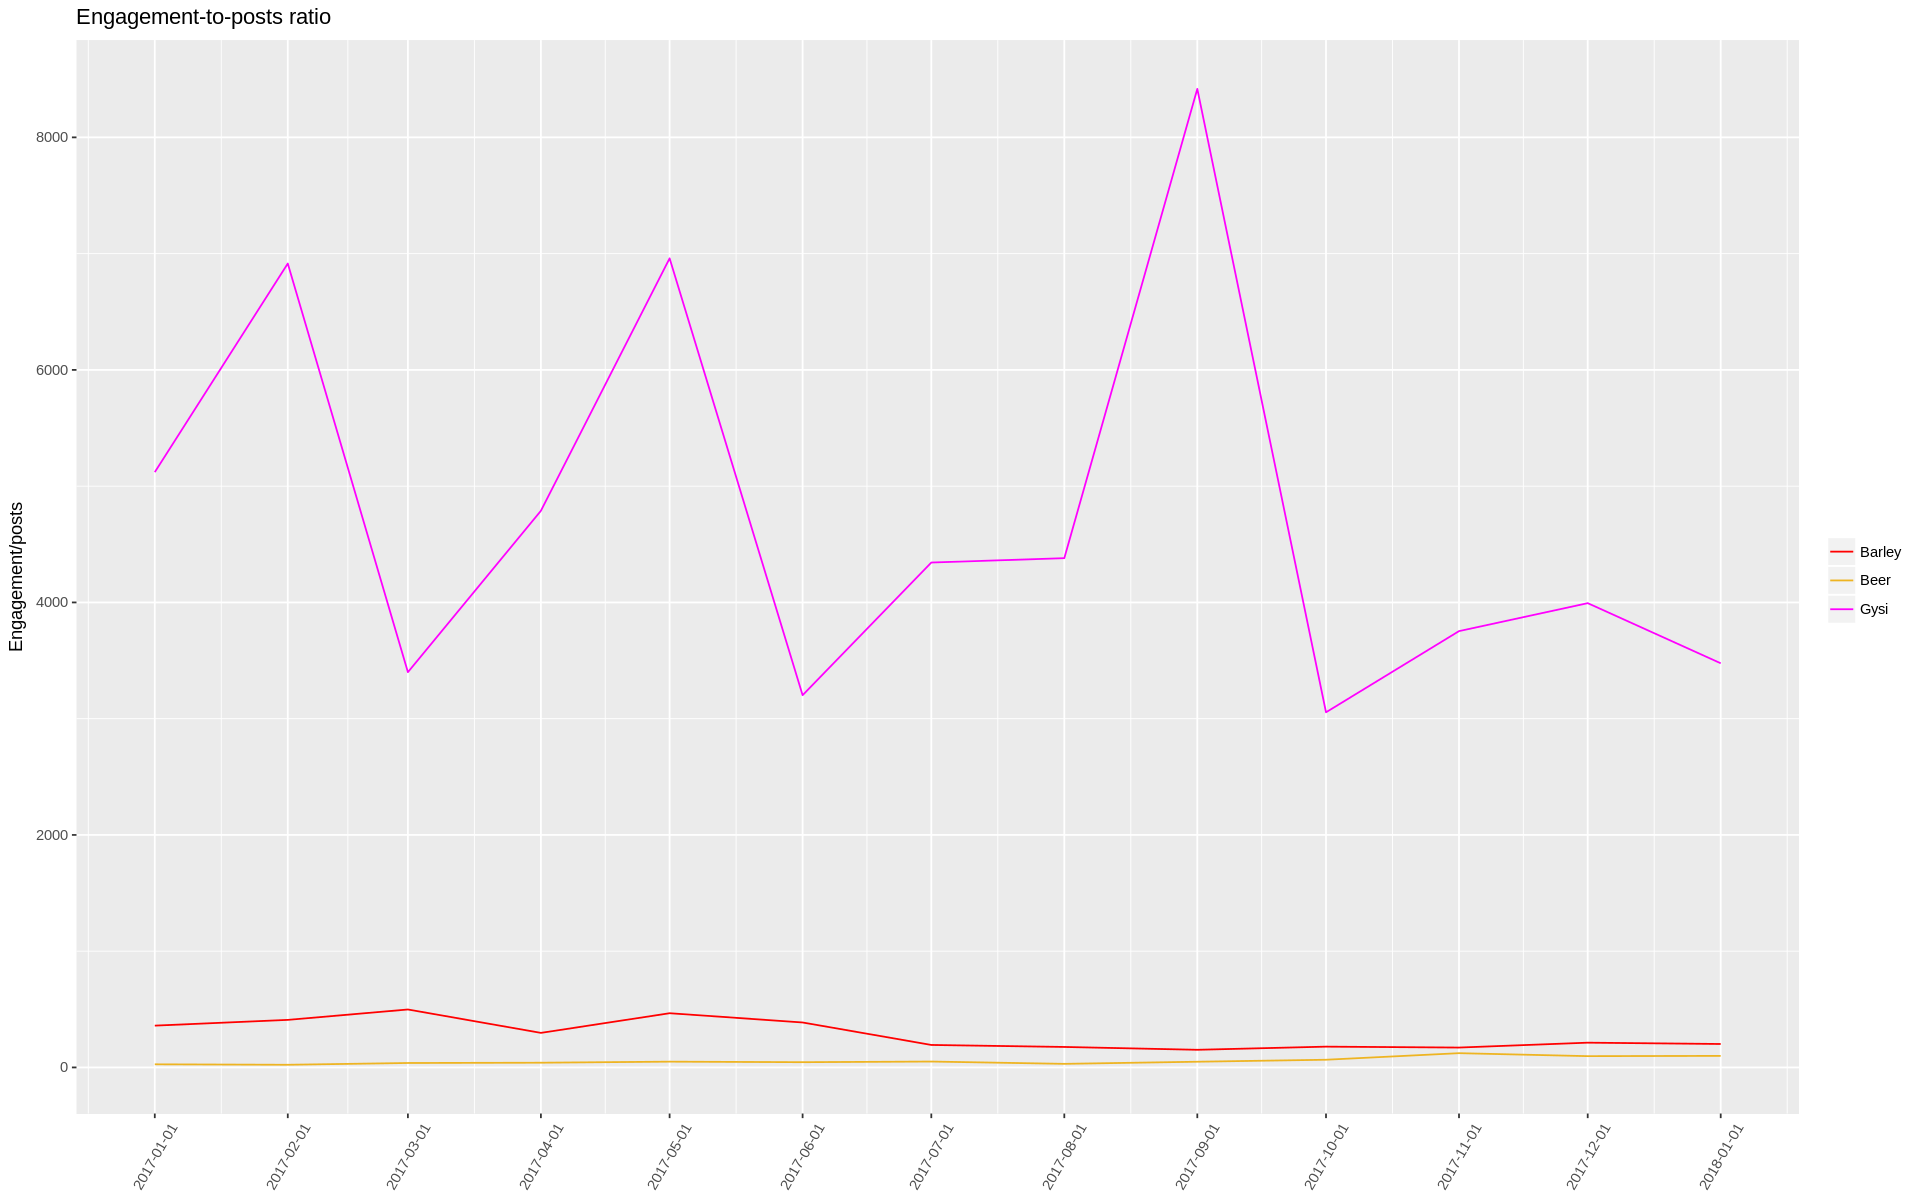

In [66]:
# plotting ratio between engagement and posts 
ggplot(data=posts_by, aes(x=as.Date(labels), y=engagement/values)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Engagement-to-posts ratio", y = "Engagement/posts") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 

# Interesse an Wikipedia-Seiten (externe API)

In [67]:
#Dplyr macht einige Befehle kürzer, Code könnte aber auch ohne diese Library geschrieben werden

library('dplyr', warn.conflicts = FALSE)

#Hier speichern wir die "Views", d.h. Seitenaufrufe der Artikel über die Politiker auf der deutschen Wikipedia

views_all <-data.frame()

#Parameter festlegen. Dieses mal für die Wikipedia API. Diese haben (semi-zufällig) ein ähnliches Format. 

start_wp='20170701'
end_wp='20200215'
aggregation_wp='month'

# Wieder ein Loop über unsere Politikerliste. Nun geht es uns um den Namen des jeweiligen WP-Artikels

for (i in seq_along(politician_ids)){
    url_politician <- paste(base,"all/", politician_ids[i], "/", sep="")
    
    politician <- fromJSON(content(GET(url_politician), "text", encoding="UTF-8"), flatten = TRUE)
    
    # Teile der URL (nach dem Artikelnamen und davor) für WP
    pre <- "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/de.wikipedia.org/all-access/user/"
    post <- paste("/daily/", start_wp,"/", end_wp, sep="")

    # Daten von der Wikipedia API
    
    #Views werden pro Politiker wieder einem Listenelement zugewiesen
    appended_views = list()
    # Hier kreieren wir für jeden Politiker - über den zuvor abgefragten Namen ihres/seines WP-Artikels - eine individuelle Abfrage für die Views:
    for (wp_title in politician$wp_titles) {
        x <- tryCatch({
            view = as.data.frame(fromJSON(content(GET(
                paste(pre, URLencode(wp_title, reserved=TRUE), post, sep="")), "text", 
                encoding="UTF-8"), flatten = TRUE))
            appended_views <- append(appended_views, list(view))
        }, error = function(e) e )
    }
    views  <- dplyr::bind_rows(appended_views)

    # Datumsangaben ins richtige Format bringen
    views$items.timestamp<-as.POSIXct(strptime(views[["items.timestamp"]], format='%Y%m%d%H'),tz = 'GMT')

    # Nachdem wir "daily" abgefragt haben, können wir noch runterbrechen
    views <- summarise(group_by(views, time = cut(items.timestamp, aggregation_wp)), items.views = sum(items.views))
                      
    #Nachnamen des Politikers nochmal von SMM API holen zum Plotten (hätte man auch von oben speichern können, aber na ja)
    views[['politician_name']] <- fromJSON(content(GET(paste(base,"all/", politician_ids[i], "/", sep="")), "text", encoding="UTF-8"), flatten = TRUE)$name
    views_all <- rbind(views_all, views)
                      }

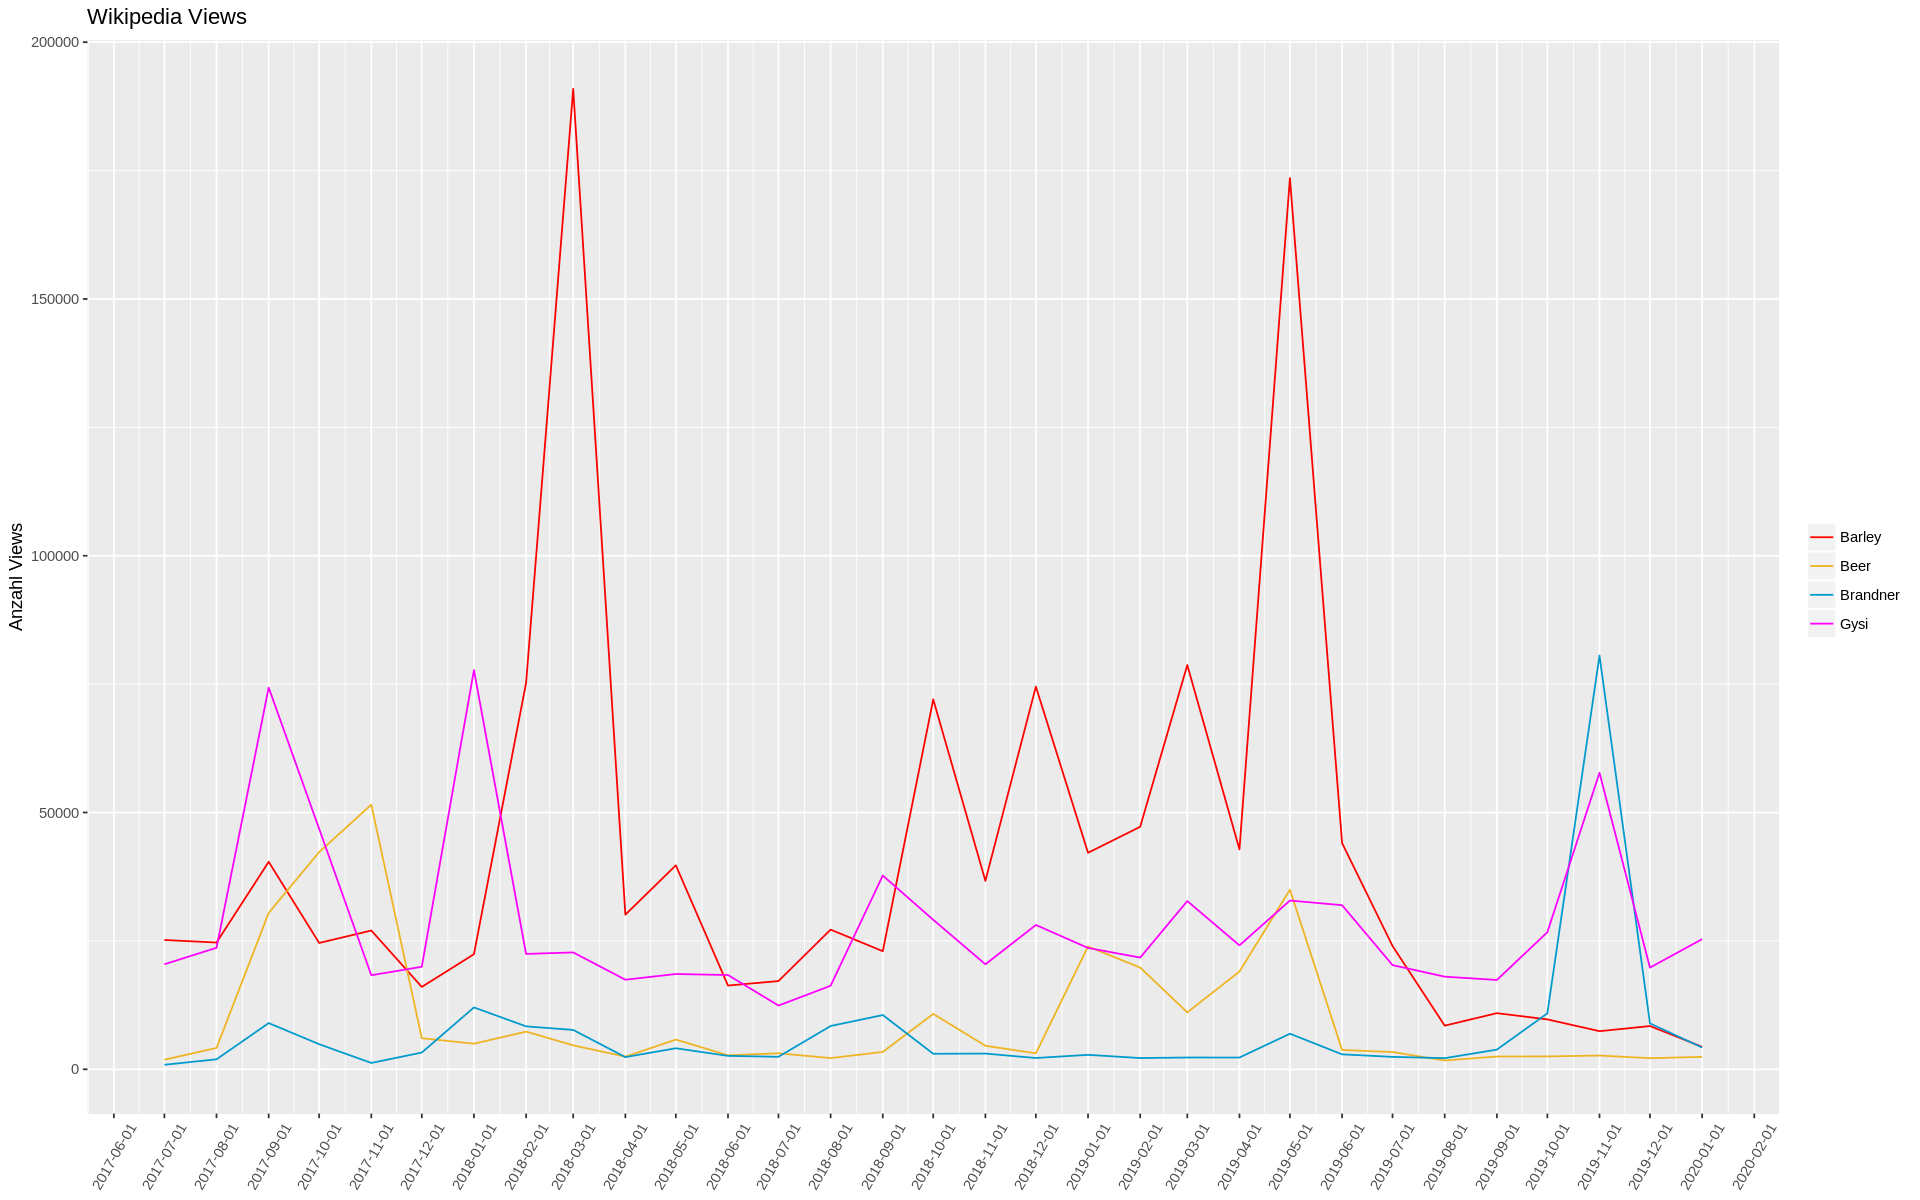

In [68]:
#Plotting: Wikipedia Views
ggplot(data=views_all, aes(x=as.Date(time), y=items.views)) + 
    geom_line(aes(colour = factor(politician_name))) + 
    theme(axis.text.x = element_text( angle = 60, hjust = 0.5, vjust = 0.5),
        axis.title.x = element_blank(), legend.title = element_blank()) +
    labs(title = "Wikipedia Views", y = "Anzahl Views") +
    scale_color_manual(name='politician_name',values=color_palette) +
    scale_x_date(date_breaks = "1 month") 